# Classification Model Execution using DeepSparse Engine

This notebook provides an example of how to perform inference on a pretrained, dense classification model using the DeepSparse Engine, with the model and sample data provided by SparseZoo.

You will:
- Download your exported pretrained ONNX model of choice and sample data from SparseZoo
- Compile a CPU-optimized executable of that model with the DeepSparse Engine
- Run that model with real data
- Verify the accuracy of the model
- Benchmark the speed of the model

## Setup

To run this notebook you will need to have installed:
- DeepSparse Engine and SparseZoo
- Matplotlib for visualization of the results

Feel free to install any package you require using `pip`.

In [1]:
import deepsparse
import sparsezoo

import json
import numpy

def calculate_top1_accuracy(pred: numpy.array, labels: numpy.array):
    """
    :param pred: the models prediction to compare with
    :param lab: the labels for the data to compare to
    :return: the calculated top1 accuracy
    """
    batch_size = pred.shape[0]
    pred = numpy.argmax(pred, axis=-1)
    
    correct = (pred == labels.reshape(pred.shape)).sum()
    correct *= (100.0 / batch_size)
    
    return correct

## Gathering the Model and Data

By default, you will download a MobilenetV1 model trained on the Imagenet dataset.
The model's pretrained weights and exported ONNX file are downloaded from the SparseZoo model repo.
The sample batch of data is downloaded from SparseZoo as well.

If you want to try different architectures replace `mobilenet_v1()` with your choice, for example: `resnet50()` or `efficientnet_b0()`.

You may also want to try different batch sizes to evaluate accuracy and performance for your task.

In [2]:
from sparsezoo.models import classification 

# =====================================================
# Define your batch size for inference below
# =====================================================
batch_size = 16

# =====================================================
# Define your model below
# =====================================================
model = classification.mobilenet_v1()

# Gather sample batch of data for inference and visualization
batch = model.sample_batch(batch_size=batch_size)
batched_inputs = batch["inputs"]
batched_outputs = batch["outputs"]
batched_labels = batch["labels"]

downloading...: 100%|██████████| 775926/775926 [00:00<00:00, 10595424.91it/s]


KeyError: 'labels'

## Compile Model for Inference

The DeepSparse Engine will compile your model into an optimized executable for inference for a given batch size, making use of natural sparsity that arises from traditional deep learning flows.

By default, it will make use of all physical cores on your system. Feel free to adjust the `num_cores` parameter.

In [11]:
from deepsparse import compile_model, cpu
CORES_PER_SOCKET, AVX_TYPE, _ = cpu.cpu_details()

# =====================================================
# Define the number of cores to use
# =====================================================
num_cores = CORES_PER_SOCKET

print("Compiling {} model with DeepSparse Engine".format(model.architecture_id))
engine = compile_model(model.onnx_file.downloaded_path(), batch_size, num_cores)
print(engine)

Compiling mobilenet_v1-1.0 model with DeepSparse Engine
deepsparse.engine.Engine:
	onnx_file_path: /home/mgoin/.cache/sparsezoo/23f12cd6-c38e-4353-b414-967ca0a4e631/model.onnx
	batch_size: 16
	num_cores: 18
	num_sockets: 1
	cpu_avx_type: avx512
	cpu_vnni: False


## Inference

Now that the model has an engine compiled for it, we can feed it inputs and get predicted outputs.

Using SparseZoo, we can compare the predicted output against the ground-truth classes to validate the model is still accurate.

In [3]:
from deepsparse.utils import verify_outputs

# Record output from inference through the DeepSparse Engine
print("Executing...")
predicted_outputs = engine(batched_inputs)

# Compare against reference model output
verify_outputs(predicted_outputs, batched_outputs)

# Measure accuracy against ground truth labels
predicted_labels = numpy.argmax(predicted_outputs[-1], axis=-1)
accuracy = calculate_top1_accuracy(predicted_outputs[-1], batched_labels[0])

print("Top-1 Accuracy for batch size {}: {:.2f}%".format(batch_size, accuracy))

Executing...


NameError: name 'engine' is not defined

## Benchmarking

The DeepSparse Engine exposes simple interfaces to benchmark its inference speeds over a variety of situations. 

The result of these benchmarks can be viewed in intuitive ways that help you understand where you can deploy the Engine, with measurements like `items_per_second` readily available.

In [9]:
benchmark_result = engine.benchmark(batched_inputs, num_iterations=50, num_warmup_iterations=10)
print(benchmark_result)

BenchmarkResults:
	items_per_second: 1097.1961920058807
	ms_per_batch: 14.582624435424805
	batch_times_mean: 0.014582624435424804
	batch_times_median: 0.013310909271240234
	batch_times_std: 0.00208239724489642


## Visualizing Results

To further visualize the results of your inference, you can view the input data as the original images with their predicted labels using Matplotlib.

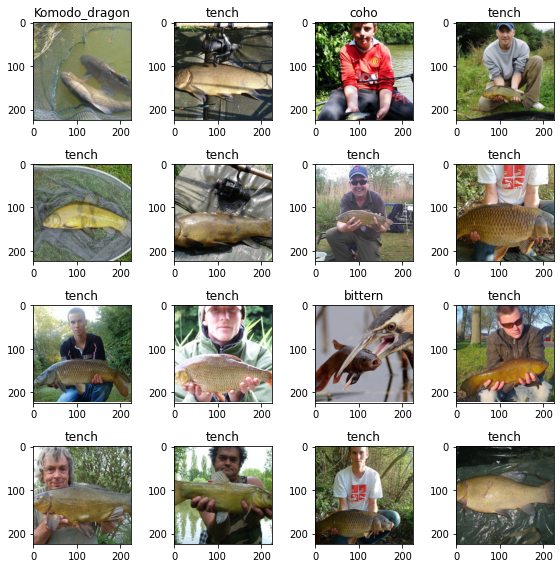

In [10]:
from matplotlib import pyplot as plt
import json

# Load in imagenet transform information and label mappings
with open("imagenet.json") as f:
    imagenet_data = json.load(f)


# Plot each input image with predicted label from model inference
nrows = ncols = int(numpy.sqrt(batch_size))
fig, ax = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows))
i = 0
for row in ax:
    for col in row:
        label = predicted_labels[i]
        image = batched_inputs[0][i].copy()

        # Transform input tensor back to original values and structure
        pixels = numpy.transpose(image, (1,2,0))
        pixels = (pixels * imagenet_data["transforms"]["normalize-std"]) + imagenet_data["transforms"]["normalize-mean"]
        pixels = numpy.clip(pixels, 0.0, 1.0)
        
        # Draw image and predicted label
        col.imshow(pixels)
        col.set_title('{}'.format(imagenet_data["label_mappings"][str(label)]))
        
        i += 1

plt.tight_layout()
plt.show()

## Next Steps

Great job - you have downloaded a model from SparseZoo, used the DeepSparse Engine for inference, and validated the output!

Next steps to pursue include:

- Try other classification models from SparseZoo
    - Pruned versions of the model to see unstructured sparsity speedup on the DeepSparse Engine
    - Other architectures: ResNet, EfficientNet, Inception
- Use benchmarking scripts to compare performance across models and inference engines